## Wikidpedia page views and Signal Processing of Time Series
### by Daniel for the Meetup group, Scientists New to Data Science

This notebook takes a look at Wikipedia page views. Wikipedia might be thought of as a proxy for other other media channel interest. For instance, national interest on the cancer drug Tarceva. It's difficult to get a long history of content views from Twitter, Youtube, Facebook, etc...but Wikipedia offers a full 7 seven years of basic usage stats. 
I have three goals with this notebook

* Present Wikipedia as a proxy to guage interest in a topic
* Provide example of time series analysis
* Try to make market analysis with the data

In addition, the contributor's stats on edits is available. That also might yield some interesting analysis. For instance the page maintainers for a drug, might well be a key influencer in the field. Or, the time series data
which belongs to an editor, might be used as a co-variate to be removed.

#### For now, let's restrict ourselves to page views.

It's importand to note, that Tarceva is the trade name for Erlotinib Hydrochloride.
The Wikipedia page view stats do not always use the original article name. This is true in the case of the
Tarceva page, where the page view stats use the "Erlotinib" name in the URL. This occurs again with Iressa.

In [88]:
%matplotlib inline
# this sets up the default fig size
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 5)
import urllib2
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json
from time import sleep

class WikiViews(object):
    def __init__(self, url, start_date, end_date):
        self.url = url
        self.url_base = "http://stats.grok.se/json/en/%(date)s/%(url)s" 
        self.date_range = pd.date_range(start=start_date, end=end_date, freq='m')

    def loop_over_full_dates(self):
        DF = pd.DataFrame()
        
        for date in self.date_range:
            date_string = date.strftime("%Y%m")
            url = self.url_base %{'date':date_string,
                                  'url':self.url
                                  }
           
            try:
                response = urllib2.urlopen(url)
                out = response.read()
            
            except urllib2.HTTPError:
                continue # skip this point
                         # I used to retry but stopped for economy of time
            
            except Exception, err: # modicum of trouble shooting
                #print err          # mystery failures
                #print url
                continue
                #raise Exception
                
            out = json.loads(out) # first column happens to be a date string, which will become the index
            df = pd.DataFrame(out) 
            
            DF = DF.append(df)
            DF = DF.reindex(fill_value=0) # make sure that all days are filled for later comparison
            
        return DF
    
    @classmethod # shouldn't need class instance for this but it nice to keep organized in one place
    def plot_time_series(self, df, norm=False):
        '''Plot time series average per month and print labels '''
        grp = df.groupby('month')
        y = grp.sum()
        
        if 'daily_views' in y.keys(): # case when df is a single output of loop_over_full_dates
            y = y['daily_views']
        else:                         # case for df concatentation
            pass
        
        if norm:
            y /= np.std(y)
        
        plt.plot(y)      
        plt.grid(True)
        plt.title("Daily Views Summed Over Months")
        plt.ylabel("Views per month")
        plt.xlabel("Date")
        plt.xlim(0, y.shape[0])
        
        interval = 2
        labels = df.month.unique()
        labels = labels[0::interval]
        
        n = np.arange(len(y))[0::interval]
        plt.xticks(n, labels, rotation='vertical')      
    
    @classmethod                
    def fft(self, data):
        '''Plot FFT using Welch's method, daily resolution '''
        #plt.figure(figsize=(13, 7))
        f, y = scipy.signal.welch(data, fs=1.0, nperseg=256, noverlap=128, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1/f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        
        plt.grid(True) # not working likely b/c of conflict with seaborn artist
        plt.title("Welch FFT: Wiki Views")
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs



In [148]:
wv = WikiViews("Erlotinib", '1/1/2008', '10/1/2015' )
tar = wv.loop_over_full_dates()

<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/200807/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/200808/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/200905/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201011/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201012/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201112/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201204/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201208/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201303/Erlotinib
<urlopen error [Errno -2] Name or service not known>
http://stats.grok.se/json/en/201406/Erlotinib


In [150]:
tar.head()

,daily_views,month,project,rank,title
2008-01-01,47,200801,en,-1,Erlotinib
2008-01-02,133,200801,en,-1,Erlotinib
2008-01-03,118,200801,en,-1,Erlotinib
2008-01-04,108,200801,en,-1,Erlotinib
2008-01-05,72,200801,en,-1,Erlotinib


Let's take a look a the time series data averaged per month.

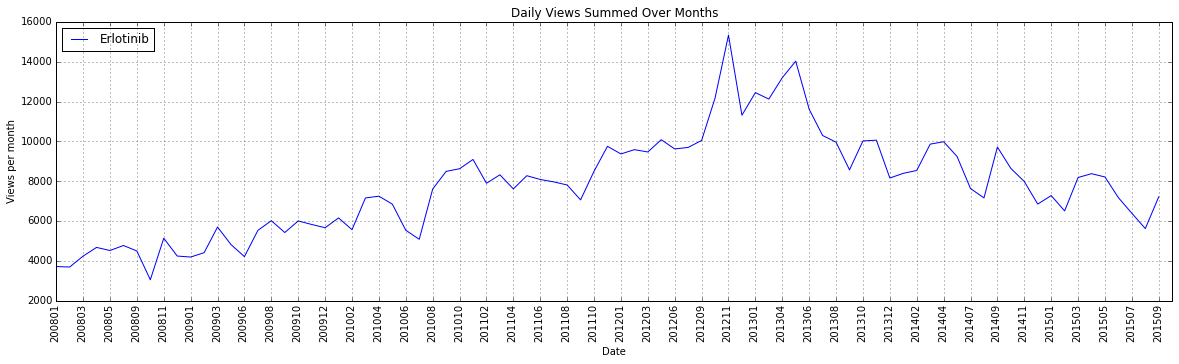

In [183]:
WikiViews.plot_time_series(tar)
plt.legend((tar.title.unique()), loc="upper left")  

## We want to explain this behavior

We'd like to be able to know what high level topics influence the interest in the drug Tarceva.
We'll look for covariates and try to come up with some entry point ideas that we would present to a domain
export or analyst.

We would want to talk to a domain expert about that. Of course we an do some google searches of our own and try to find covariates. 

Google search about Tarcea turns up:

* Acts on, "Epidermal growth factor receptor" 
* Tarceva is also used to treat
 * Non small cell lung cancer
 * Pancreatic 
* Older drug named Iressa is the predecessor

Might as well do some more Wikipedia pulls, because it will be hard to find source to cross reference in the news that covers a span of time. Let's try more topics.

In [34]:
wv = WikiViews("Epidermal_growth_factor_receptor", '1/1/2008', '10/1/2015'  )
egfr = wv.loop_over_full_dates()

In [35]:
wv = WikiViews("Lung_cancer", '1/1/2008', '10/1/2015')
lung = wv.loop_over_full_dates()

In [36]:
wv = WikiViews("Gefitinib", '1/1/2008', '10/1/2015' )
iressa = wv.loop_over_full_dates()

In [37]:
tar['date'] = df.index
df = pd.concat({'date':tar.date,
                'month':tar.month, 
                'tar':tar.daily_views, 
                'egfr':egfr.daily_views,
                'lung':lung.daily_views,
                'iressa':iressa.daily_views
               }, axis=1)

df.to_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_data.csv", index=False)

In [39]:
df.head()
dfcopy = df.copy()

I kept coming back to this notebook for work on it and didn't want to wait for the data to download.
Below I'm loading it back from a csv file.

In [48]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_data.csv")
df.set_index("date", drop=True, inplace=True)
df.head()

,egfr,iressa,lung,month,tar
date,,,,,
2008-01-01,64,40,1357,200801,47
2008-01-02,156,81,2205,200801,133
2008-01-03,213,100,2728,200801,118
2008-01-04,174,89,2582,200801,108
2008-01-05,87,53,1885,200801,72


Examine for correlation by eye. We need to normalize to correct for scale. Note, the y label units will not be 
applicable for this plot.

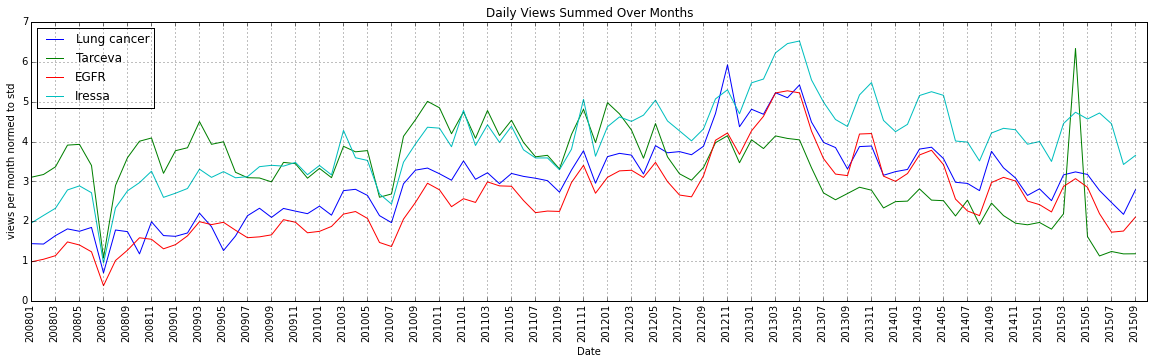

In [177]:
WikiViews.plot_time_series(df[['tar', 'lung', 'egfr', 'iressa', 'month']], norm=True)
plt.legend(('Lung cancer', 'Tarceva', 'EGFR', 'Iressa'), loc="upper left")
plt.ylabel("views per month normed to std")

## Correlation

Recall, this is just a very basic exercise. We are using really obviously connected information to form a quick and dirty report suitable for an analysis to look at on day one of a project. We will need to search more for data which could be used to predict.

Examination by eye of the above plots, looks like all 4 topics are roughly correlated in time.
It's good to get a quantifier though. Tarceva and Lung Cancer have a relatively small correlation compared to EGFR.




In [62]:
df[['tar', 'egfr', 'lung', 'iressa']].corr()

,tar,egfr,lung,iressa
tar,1.000000,0.821299,0.210851,0.774580
egfr,0.821299,1.000000,0.227172,0.872449
lung,0.210851,0.227172,1.000000,0.235276
iressa,0.774580,0.872449,0.235276,1.000000


## Seaborn 
http://stanford.edu/~mwaskom/software/seaborn/

I'm still new to Seaborn and I wanted to try it out in this exercise. I'm learning a lot about stats just reading the docs. 

In [63]:
#%matplotlib inline
#import seaborn as sns

#sns.jointplot(x="tar", y="egfr", data=df, kind="reg")

## GLM with statsmodels

In [50]:
import statsmodels.api as sm
signal = df['tar']
cov = df[['egfr','iressa','lung']]
cov = np.asarray(cov.astype(np.float32))

signal = np.asarray(df['tar'].astype(np.float32))

# GLM
model = sm.GLM(signal, cov, family=sm.families.Gaussian())   
res = model.fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2860
Model:                            GLM   Df Residuals:                     2857
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                   5785.60152446
Method:                          IRLS   Log-Likelihood:                -16445.
Date:                Sat, 10 Oct 2015   Deviance:                   1.6529e+07
Time:                        00:23:10   Pearson chi2:                 1.65e+07
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3221      0.011     28.216      0.000         0.300     0.344
x2             0.4569      0.032     14.358      0.0

# Moving on with numerical analysis technics
##  Filtering and FFT

Now we'd like to see some frequency anaylsis. The FFT won't tell us what day(s) the cycles repeat on,
but it will show if any periodicity exists. 

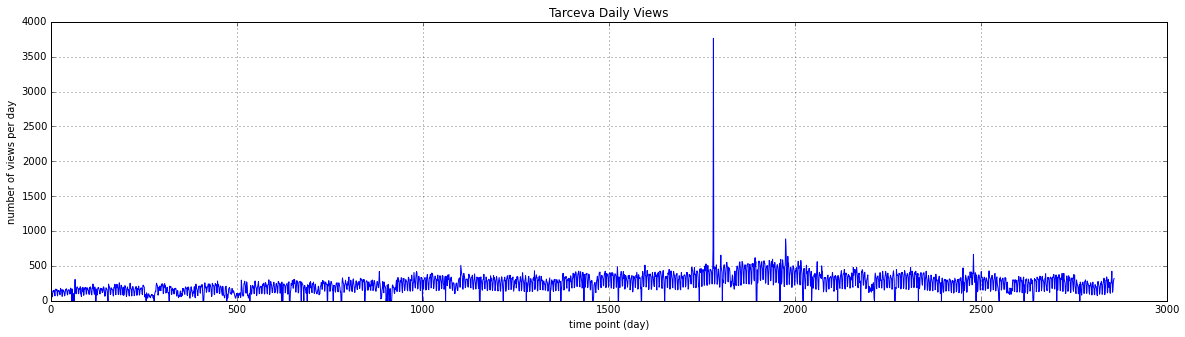

In [184]:
tar = df.tar
plt.plot(tar)
plt.grid(True)
plt.title("Tarceva Daily Views")
plt.ylabel("number of views per day")
plt.xlabel("time point (day)")

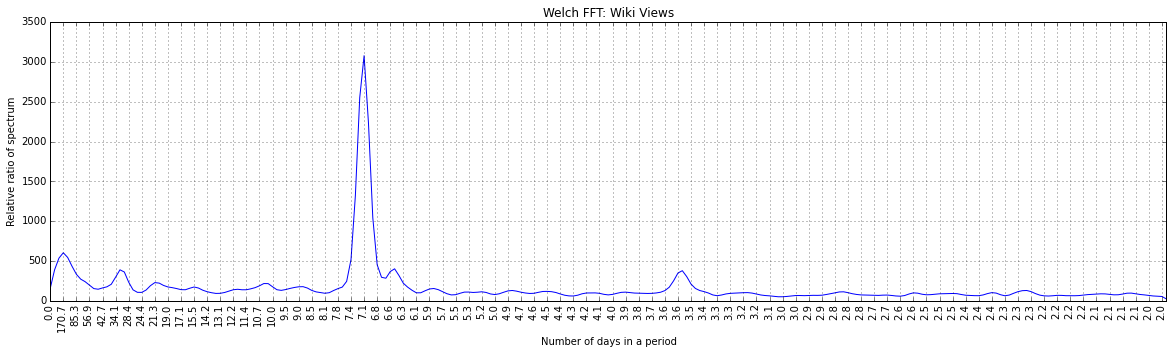

In [66]:
f, y, frq = WikiViews.fft(tar)

There's a clear weekly frequency that I've seen in other social media channels. People may look use Wikipedia on the weekends more so than weekdays. The longer periods are interesting at about a month and three months. The next step would be to look for covarites to explain the time series and the periodicity. 

### Let's do some signal processing, in particular, Filtering
With straight numeric data from sensors ( typically voltages ), it's a lot more straight forward not to process the signals. There's samplerates, signal to noise ratios, published bandwidths....with social media NONE OF THAT EXISTS ! We either get our own parameters from more data or make heuristic guesses.

In [67]:
import scipy.signal as sig
data = df.tar

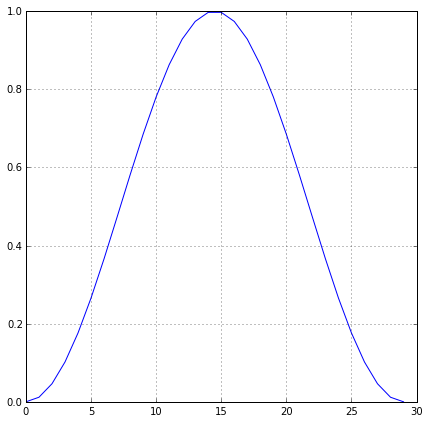

In [69]:
window = np.hanning(30)
plt.figure(figsize=(7,7))
plt.plot(window)
plt.grid(True)

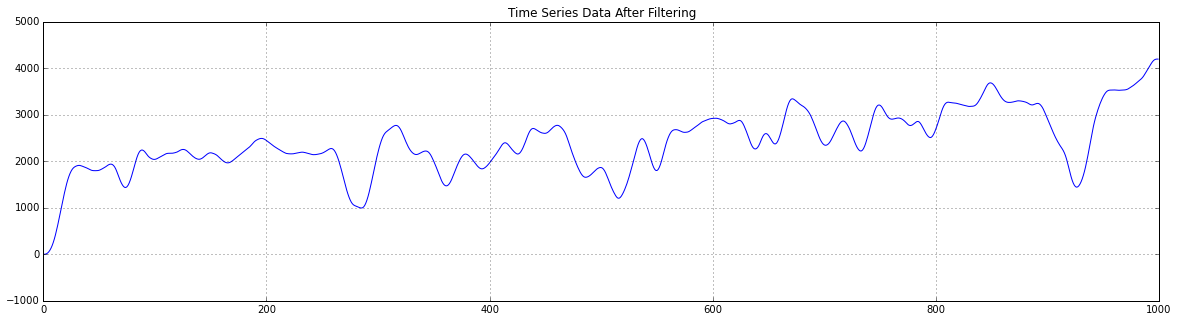

In [71]:
data_filt_30 = sig.fftconvolve(window, data)
plt.plot(data_filt_30[0:1000])
plt.grid(True)
plt.title("Time Series Data After Filtering")

## Before the Filter

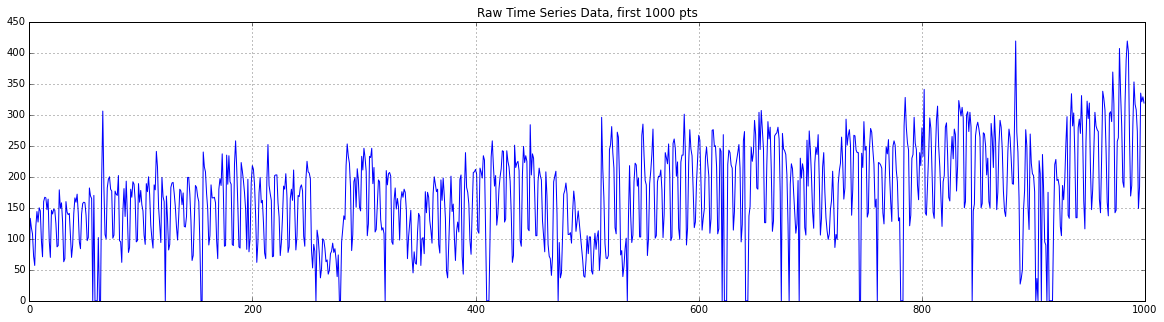

In [74]:
plt.figure()
plt.plot(data[0:1000])
plt.grid(True)
plt.title("Raw Time Series Data, first 1000 pts")

(0.0, 0.17578125)

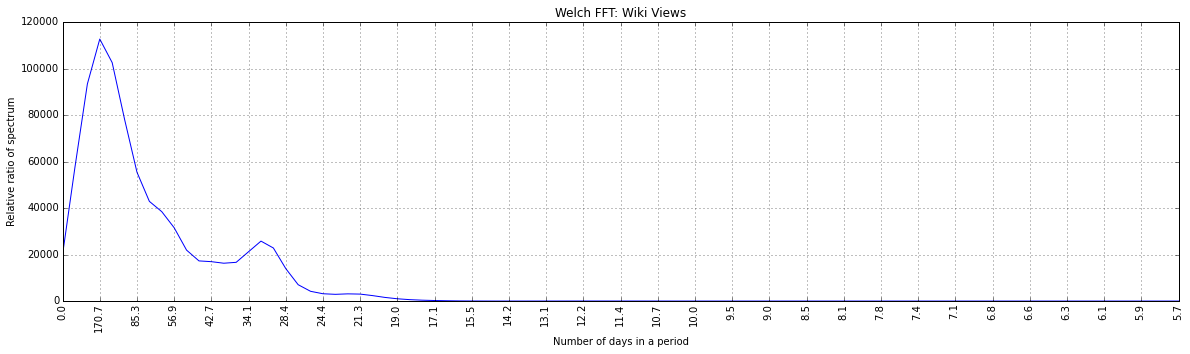

In [75]:
freq, y, frqs = WikiViews.fft(data_filt_30)
plt.xlim(frqs[0], frqs[30])

Although the peak looks bigger, there is no straight forward way to scale the y axis so we need to 
not be too impressed with that. Really, the same two peaks are present as in the original FFT. This plot is simply cleaner. This might seem dumb, but if we where writing a peak-detector, then we'd want a simpler data set.

Let's find peaks.

In [76]:
import SignalProcessTools
sigtools = SignalProcessTools.SignalProcessTools()

### The Savitzky-Golay filer was taken from here: http://wiki.scipy.org/Cookbook/SavitzkyGolay

In [77]:
def peak_detection(data):
    der1 = sigtools.savitzky_golay(data, window_size=3, order=1, deriv=1)
    der2 = sigtools.savitzky_golay(data, window_size=5, order=2, deriv=2)
    zero_crossings_test = der1[0:-1] * der1[1:]
    peaks = np.where((der2[0:-1] < 0) & (zero_crossings_test < 0))[0]
    
    return peaks

In [78]:
peaks = peak_detection(data_filt_30)

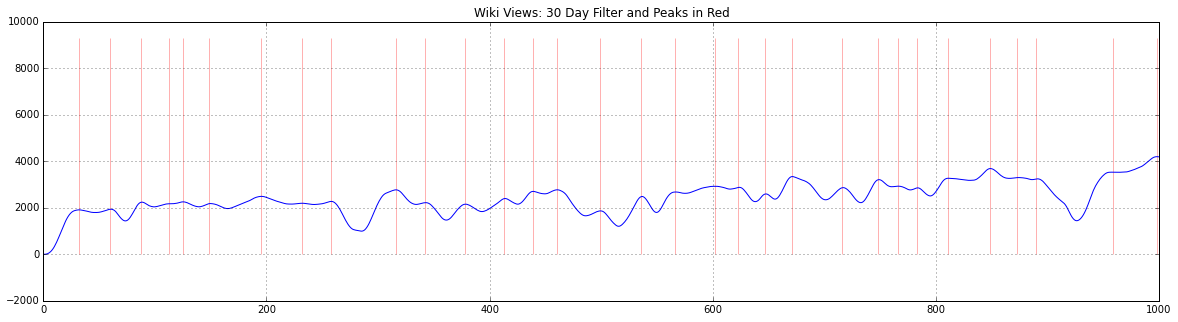

In [81]:
plt.plot(data_filt_30)
plt.grid(True)
plt.xlim(0, 1000)
plt.vlines(peaks, 0, data_filt_30.max(), 'r', alpha=0.3)
plt.title("Wiki Views Tarceva: 30 Day Filter and Peaks in Red")
plt.legend(('Tarceva Views', 'Peak'))

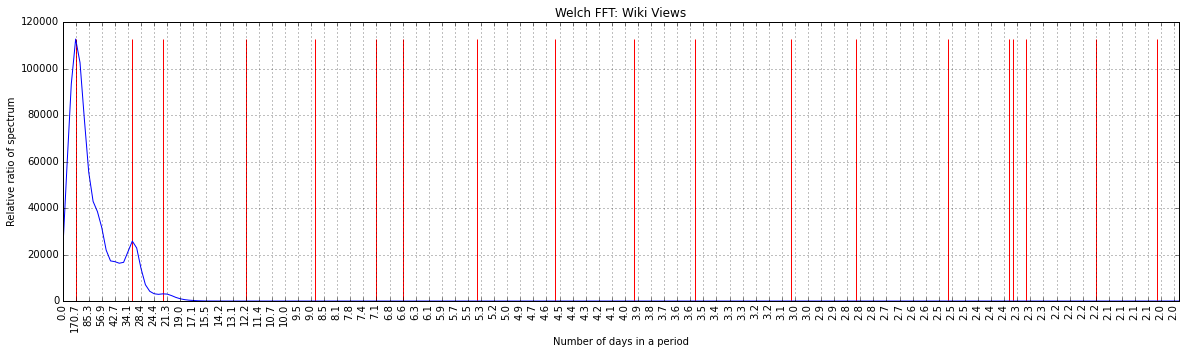

In [82]:
peaks = peak_detection(y)
plt.figure()
freq, y, frqs = WikiViews.fft(data_filt_30)
plt.vlines(freq[peaks], 0, y.max(), 'r')
plt.legend(('Tarceva Views', 'Peak'))

### There's still some ripple out to the right. We'll still need to use logic.

That ripple is most likely just noise from the convolution of delta function during sampling with the actual signal.

The odd harmonics are carried over by the Convolution-Theorm. Using Welch's method helps but does not elleviate the issue.

In [84]:
y_peaks = y[peaks]
freq_peaks = freq[peaks]

peak_ref = np.max(y_peaks)
keep_peaks = np.where(y_peaks >= 0.1 * peak_ref)[0]

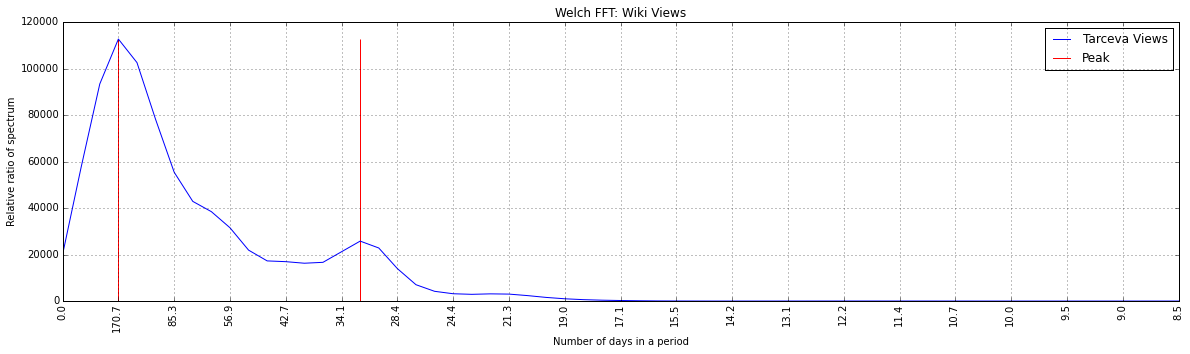

In [190]:
freq, y, frqs = WikiViews.fft(data_filt_30)
plt.vlines(freq_peaks[keep_peaks], 0, y_peaks.max(), 'r')
plt.xlim(frqs[0], frqs[20])
plt.legend(('Tarceva Views', 'Peak'))

## Get Random Pages

I'd like to see if there's a general viewing trend with Wikipedia. To do that, I'll need to select pages at random.
Luckly, WP provides an API for that.

In [210]:
import re
obj = re.compile(r'"wgPageName":"(?P<name>\w.*?")') #TODO: use BS to parse out JSON then parse json

def get_random_name():
    random = 'https://en.wikipedia.org/wiki/Special:Random'
    response = urllib2.urlopen(random)
    src_out = response.read()
    response.close()
    
    match = obj.search(src_out)
    #"wgPageName":"foo_bar_bash"
    if match:
        page_name = match.group('name')
        return page_name.replace('"','') # hack to fix above hack
    else:
        return None # handles the case when the page name is not the same as the stats page name

In [211]:
rand_page = get_random_name()
print rand_page
wv = WikiViews(rand_page, '1/1/2008', '10/1/2015' )
test_df = wv.loop_over_full_dates()

Sambhav_Asambhav


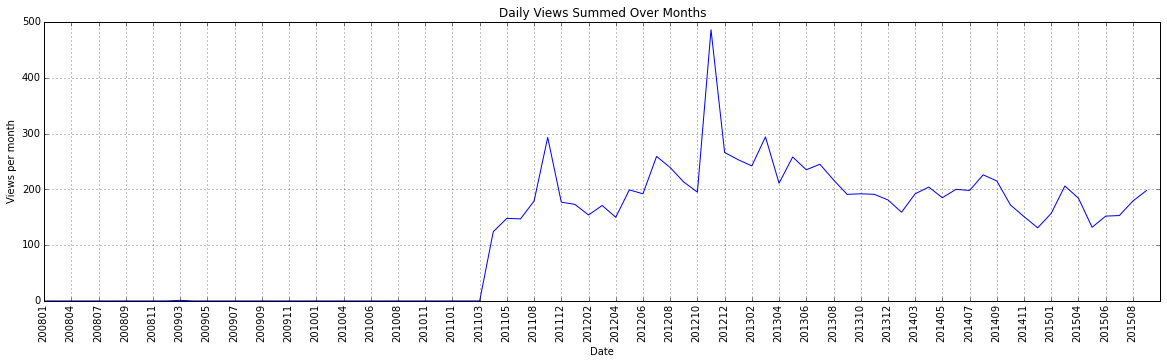

In [212]:
WikiViews.plot_time_series(test_df)

We can see, that not all pages have the same length of history. That will cause problems.
Let's build a collection of random page though and deal with it.

In fact I think a linear weight will handle the above bias.

The other bias I know for certain, is that not all the Wikipedia page view stat pages are named after the
normal article page. I'll wager that will bias in come messed up way. This is still really a first iteration so 
I'm not going to try and fix everything.

I may add the url checker routine later...



In [214]:
def build_random_data_set(df):
    rand_page = get_random_name()
    print rand_page
    if rand_page is not None:
        wv = WikiViews(rand_page, '1/1/2008', '10/1/2015' )
        rand_data = wv.loop_over_full_dates()
        df[rand_page] = rand_data['daily_views']
    
    return df

In [418]:
for i in range(20): # increase when done testing etc
    df = build_random_data_set(df)

df.to_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_random_data.csv", index=False)

Bagarmossen_Kärrtorp_BK
Allenwood
Fargo_Moorhead_Metro_Area_Transit
Forres
Get_Water!
Mahadev,_Nepal
Trudelj
Gholaman-e_Olya
National_Archives_of_Malaysia
Osetno,_Warmian-Masurian_Voivodeship
Penny_capitalism
Qormi_F.C.
Lopez,_Quezon
Little_Wilson_and_Big_God
Young_Ace
Toyota_Automobile_Museum
1974_Currie_Cup
Stephanie_Daley
Joyce_Vincent_Wilson
Albert_Julius_Otto_Penzig


In [419]:
df.head()

,egfr,iressa,lung,month,tar,"Evergreen,_Edmonton",Donkey_Punch_(pornographic_film),Bagarmossen_Kärrtorp_BK,Allenwood,Fargo_Moorhead_Metro_Area_Transit,...,Penny_capitalism,Qormi_F.C.,"Lopez,_Quezon",Little_Wilson_and_Big_God,Young_Ace,Toyota_Automobile_Museum,1974_Currie_Cup,Stephanie_Daley,Joyce_Vincent_Wilson,Albert_Julius_Otto_Penzig
date,,,,,,,,,,,,,,,,,,,,,
2008-01-01,64,40,1357,200801,47,0,0,0,4,0,...,0,0,16,0,0,3,0,30,43,0
2008-01-02,156,81,2205,200801,133,0,0,0,4,0,...,0,0,13,0,0,1,0,39,30,0
2008-01-03,213,100,2728,200801,118,0,0,0,3,0,...,1,0,22,0,2,3,0,35,48,0
2008-01-04,174,89,2582,200801,108,0,0,0,8,0,...,0,0,31,0,0,8,0,28,35,0
2008-01-05,87,53,1885,200801,72,0,0,0,7,0,...,2,0,12,0,0,4,0,39,39,0


# Averaging Time Series

I know that our data has holes from failed HTTP requests, and those will show up as NaN's.
Also, some time series are shorter than others. A simple mean will bias the samples b/c of the zeros.

Also, zeros add hard harmonics in the FFT.

For a first iteration, I'm going to normalize by the range and set all NaN's to zero.
I'm interested in the periodic viewership in general, per article.

Then I'll interpolate the zeros in the mean to reduce ripple in the FFT.

## Better way

A better way might be to truncate the time series with leading zeros. 
Interpolate the sparse zeros and FFT each separately. 
Then average all the FFT results weighting each by the percentage of points that a vector 
supplied to the total.

In [90]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/wiki_views_random_data.csv")
df.shape

(2860, 126)

In [53]:
arr = df.drop("month", axis=1,inplace=False).as_matrix()
arr = arr.astype(np.float32)
arr.shape

(2860, 125)

In [54]:
arr /= arr.max(axis=0,keepdims=True)
arr = np.nan_to_num(arr) # handle NaN's created above

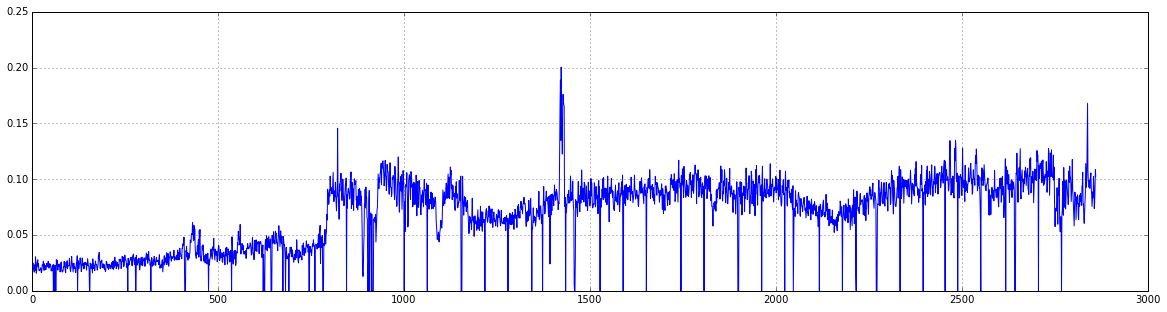

In [55]:
plt.plot(arr.mean(1))
plt.grid()

## Interpolate

Now we'll use linear interpolation to avoid the arteficial periodicity we'd get from the zeros.

In [56]:
ave_arr = arr.mean(axis=1)
z = np.where(ave_arr == 0)[0]
num = np.nonzero(ave_arr)[0]
ave_arr[z] = np.interp(z, num, ave_arr[num])

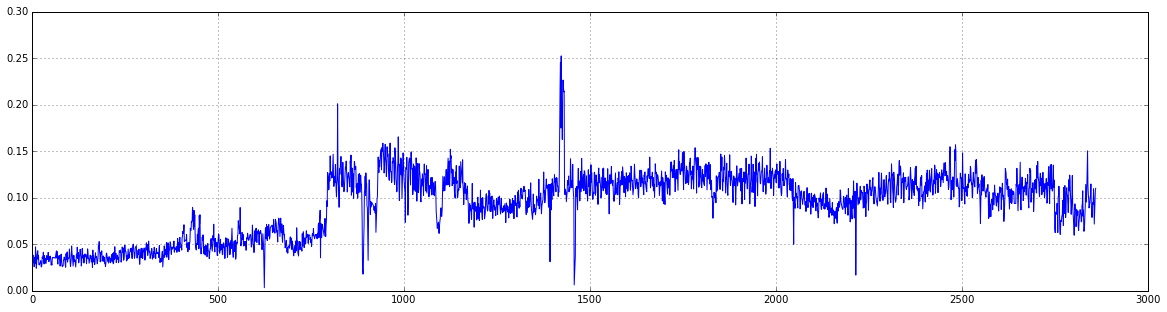

In [87]:
plt.plot(ave_arr)
plt.grid()

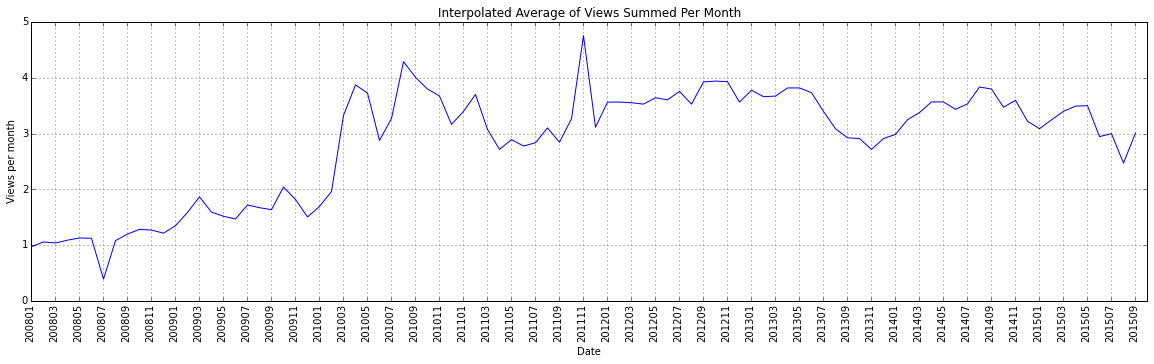

In [64]:
df['ave_arr'] = ave_arr
WikiViews.plot_time_series(df[['ave_arr', 'month']])
plt.title("Interpolated Average of Views Summed Per Month")

## Weighted Average

In [65]:
# revisit some code to get total number of points in the whole thing...to normalize with
arr2 = df.drop("month", axis=1,inplace=False).as_matrix()
arr2 = arr.astype(np.float32)
arr2 = np.nan_to_num(arr2) # handle NaN's created above

num_non_zeros = map(lambda x:len(np.where(x != 0)[0]), arr2.T)
total_points = np.sum(num_non_zeros)

w = num_non_zeros / np.float32(total_points)
print "weights:", w

ave_arr = np.average(arr, axis=1, weights=w) # applying weights to original arr

## re-interpolate

z = np.where(ave_arr == 0)[0]
num = np.nonzero(ave_arr)[0]
ave_arr[z] = np.interp(z, num, ave_arr[num])

weights: [ 0.01292748  0.01292282  0.01291816  0.01292748  0.          0.
  0.00746766  0.01291816  0.01071467  0.01292282  0.00253891  0.01169762
  0.00838539  0.00529677  0.00777978  0.00721144  0.01112462  0.01234516
  0.01291816  0.00082456  0.01110599  0.01283897  0.00123917  0.01290419
  0.01291816  0.00285569  0.000955    0.01197714  0.01271785  0.00951742
  0.00030281  0.00170503  0.00562753  0.0110035   0.00148608  0.01292282
  0.00837142  0.007081    0.01116189  0.00583716  0.00847856  0.01170694
  0.01046311  0.00096432  0.00770059  0.01083113  0.00526416  0.01293214
  0.00190535  0.00236189  0.01290419  0.00563685  0.01290885  0.01004384
  0.01289953  0.01079386  0.01078921  0.01117121  0.01290885  0.00132769
  0.01291816  0.0059909   0.0045514   0.00858571  0.00124849  0.00896771
  0.00291159  0.00164447  0.0122287   0.00606543  0.00905157  0.01131562
  0.0100252   0.00532007  0.00234791  0.00837608  0.0121495   0.01288555
  0.00631234  0.00194727  0.00829222  0.00389455  

The Welch FFT has an option to linearily detrend the data which is being  used.

([], <a list of 0 Text yticklabel objects>)

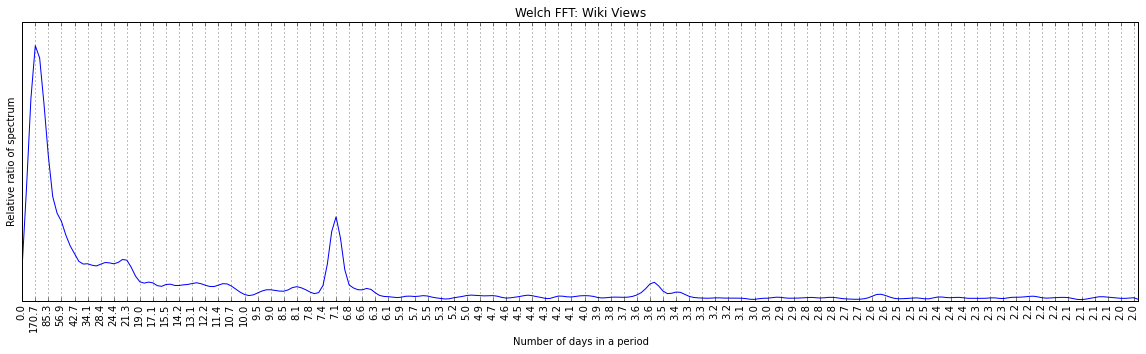

In [86]:
f, y, frqs = WikiViews.fft(ave_arr)
plt.yticks([])

In [361]:
# fft or other filter to remove periodic trends
# and  regression filter for fun with co-variates

In [91]:
170.7/30.0

5.6899999999999995